In [4]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [6]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = tf.cast(example["class"], tf.uint16)
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image) if labeled=False
    for elem in maped_dataset:
        yield elem


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath


def load_tensor_batches(generator_dataset, batch_size=128):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        batch_imgs.append(
            torch.tensor(elem[0].numpy().astype(float) / 255.0, dtype=torch.float16).permute(
                2, 0, 1
            )
        )
        batch_lbls.append(torch.tensor(elem[1].numpy(), dtype=torch.float16))
        i += 1
        if i % batch_size == 0:
            yield torch.stack(batch_imgs), torch.stack(batch_lbls)
            batch_imgs, batch_lbls = list(), list()

In [9]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [10]:
train_trf_dataset

<generator object load_dataset at 0x7c2b3775dee0>

In [11]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

batch_train_tensors = next(load_tensor_batches(train_trf_dataset))

In [12]:
batch_train_tensors[0].shape

torch.Size([128, 3, 224, 224])

tensor(63., dtype=torch.float16)


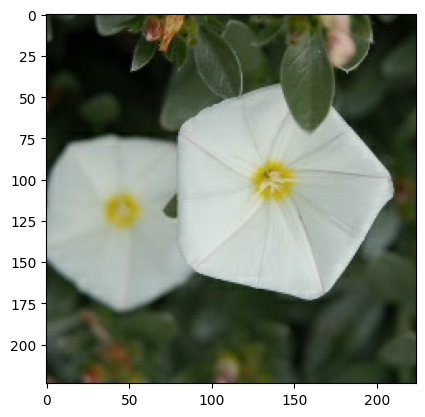

In [13]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [14]:
xm.get_xla_supported_devices()

E0000 00:00:1724916351.710628    5721 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']

In [16]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device

device(type='xla', index=0)

In [31]:
import math

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


class xlm_fully_conv(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 104),
        )

    def forward(self, batch):
        return F.log_softmax(self.model(batch), dim=1)

In [32]:
xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
output = xlm_model(batch_train_tensors[0].to(device, dtype=torch.float32))

In [33]:
output

tensor([[-4.8515, -5.3582, -4.5407,  ..., -4.5615, -5.3567, -4.7244],
        [-5.1957, -4.8212, -4.5153,  ..., -4.4340, -4.6186, -4.2756],
        [-4.8525, -4.8981, -4.2737,  ..., -4.0717, -4.4753, -5.0250],
        ...,
        [-4.9016, -4.9445, -4.8827,  ..., -3.3260, -4.9886, -4.4672],
        [-4.9364, -4.5690, -4.4986,  ..., -4.3202, -4.5837, -4.4250],
        [-4.6705, -4.2540, -4.9582,  ..., -4.2649, -4.8808, -4.7127]],
       device='xla:0', grad_fn=<LogSoftmaxBackward0>)

In [ ]:
import torch_xla.distributed.parallel_loader as pl
from sklearn import metrics
from tqdm import tqdm


xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)

num_epochs = 100
loss = nn.NLLLoss()
opt = torch.optim.Adam(xlm_model.parameters(), lr=5e-3)
batch_size = 512
rate_tracker = xm.RateTracker()

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    xlm_model.train()
    batch_generator = load_tensor_batches(
        load_dataset(get_recursive_paths(path, "train")), batch_size
    )
    train_loader = pl.ParallelLoader(batch_generator, [device])
    for i, batch in enumerate(train_loader.per_device_loader(xm.xla_device())):
        batch_img_tensor, batch_lbl_tensor = batch[0].to(device, dtype=torch.float32), batch[1].to(
            device, dtype=torch.float32
        )

        lbl_predict = xlm_model(batch_img_tensor)
        output = loss(lbl_predict, batch_lbl_tensor)
        output.backward()
        xm.optimizer_step(opt)
        opt.zero_grad()

        print(f"Loss: {output.detach().cpu()}")

        predictions = torch.argmax(lbl_predict, dim=1).detach().cpu().numpy()
        f1 = metrics.f1_score(
            batch_lbl_tensor.detach().cpu().numpy(), predictions, average="macro"
        )
        print(f"F1-score: {f1}")

        rate_tracker.add(batch_size)
        print(f"Rate: {rate_tracker.rate()} examples/sec")

        xm.mark_step()

Epoch: 0
Loss: 4.739326000213623
F1-score: 0.0033305506689941906
Rate: 20.151479737474187 examples/sec
Loss: 4.5765228271484375
F1-score: 0.008695279808181479
Rate: 19.68199874171451 examples/sec
Loss: 4.248674392700195
F1-score: 0.009283178911535005
Rate: 19.49592844553524 examples/sec
Loss: 4.054656982421875
F1-score: 0.011982788343467698
Rate: 813.0871236867573 examples/sec
Loss: 3.9667201042175293
F1-score: 0.02010066108601536
Rate: 1390.1291764414873 examples/sec
Loss: 3.9033761024475098
F1-score: 0.011827753519330013
Rate: 1671.5319790176895 examples/sec
Loss: 3.880157470703125
F1-score: 0.019556550984519337
Rate: 1784.4669516054132 examples/sec
Loss: 3.6433944702148438
F1-score: 0.022056286310993222
Rate: 1516.939694890836 examples/sec
Loss: 3.693084716796875
F1-score: 0.030704013089027524
Rate: 1684.1475466701763 examples/sec
Loss: 3.855530261993408
F1-score: 0.019610423619193525
Rate: 1785.6035502929285 examples/sec
Loss: 3.670431613922119
F1-score: 0.026562700371079554
Rate: 